In [1]:
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from __future__ import division, print_function, absolute_import
import numpy as np
import tensorflow as tf
import h5py
import glob
import sys, os
from NetworkSwitch import *
from sklearn.preprocessing import scale
from skimage.util import view_as_windows as vaw
from numpy import random as npr
from scipy.misc import imresize

In [2]:
# define useful variables
os.chdir('/home/TF_Rover/RoverData/Right2')
fnames = glob.glob('*.h5') # datasets to train on
iters = 500 # number of training iterations
batch_sz = 65  # training batch size
f_int = 5
f_int2 = 15
num_stack = 1
val_name = 'Run_218seconds_Michael_Sheri.h5' # Dataset to use for validation
imsz = 100
D = {} # dictionary to hold learned dictionaries
A = {} # dictionary to hold sparse coefficients
E = {} # dictionary to hold error rates

In [3]:
def create_framestack(x, y, f_int, f_int2):
    X_ = []
    Y_ = []
    for ex_num in range(x.shape[0]-1, f_int2, -1):
        X2 = x[ex_num-f_int, :, :, :]
        X3 = x[ex_num-f_int2, :, :, :]
        X_.append(np.concatenate((x[ex_num, :, :, :], X2, X3), 2))
        Y_.append(y[ex_num, :])
    return np.asarray(X_), np.asarray(Y_)

In [4]:
def get_patches(X, ps):
    X = vaw(X, (1, ps, ps, 3))
    subsample = np.int32(ps/2+1)
    X = X[:, ::subsample, ::subsample, ...]
    num_patches = X.shape[0]*X.shape[1]*X.shape[2]*X.shape[3]*X.shape[4]
    return np.transpose(X.reshape([num_patches, -1]))

In [5]:
def mat2ten(X):
    zs=[X.shape[1], int(np.sqrt(X.shape[0]/3)), int(np.sqrt(X.shape[0]/3)), 3]
    Z=np.zeros(zs)
    
    for i in range(X.shape[1]):
        Z[i, ...]=np.reshape(X[:,i],[zs[1],zs[2], zs[3]])
        
    return Z

In [6]:
def montage(X):    
    count, m, n, c = np.shape(X)    
    mm = int(np.ceil(np.sqrt(count)))
    nn = mm
    M = np.zeros((mm * m, nn * n, 3))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count: 
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m, :] = X[image_id, ...]
            image_id += 1
    return M

In [7]:
def plot(x):
    fig, ax = plt.subplots()
    im = ax.imshow(x, cmap='jet')
    ax.axis('off')
    fig.set_size_inches(18, 10)
    plt.show()

In [8]:
def file_get(filename):
    f = h5py.File(filename, 'r')
    X = np.asarray(f['X'])
    f.flush()
    f.close()
    return X[..., ::-1]

In [9]:
def resize_images(X, newsize):
    x = []
    
    for i in range(X.shape[0]):
        x.append(imresize(X[i, ...], [newsize, newsize]))
        
    return np.asarray(x)

In [10]:
print('Validation Dataset: %s'%(val_name))

Validation Dataset: Run_218seconds_Michael_Sheri.h5


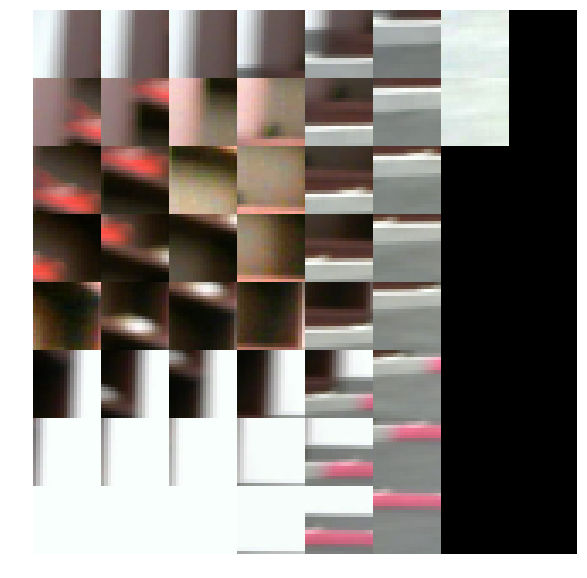

[ 0.          0.00403226  0.00406504 ...,  0.996       0.99601594  1.        ]


NameError: global name 'tf' is not defined

In [11]:
for k in range(50, 1001, 25):
    for patch_sz in range(20, 121, 20):
    

        # pick random dataset for this epoch
        n = np.random.randint(1, len(fnames)-1, 1)
        filename = fnames[n[0]]
    
        # skip validation set if chosen
        #if filename == val_name: 
        #    continue

        # load the chosen data file
        X = file_get(filename)

        # make the images smaller
        X = resize_images(X, imsz)

        # Choose 50 random images from the dataset
        X = X[npr.randint(0, X.shape[0], 50), ...]

        # take patches out of the images 
        X = get_patches(X, patch_sz)

        # scale the pixel values down to between 0 and 1
        X = X / np.amax(X, 0)

        # plot some of the patches
        plot(montage(mat2ten(X[:, :50])))
        print(np.unique(X))

        # name to save each dictionary and coefficients as 
        save_name = str(k) + '_' + str(patch_sz)

        # send data to network and get back dictionary and coefficients
        D[save_name], A[save_name], E[save_name] = X3(X,
                                                      iters,
                                                      batch_sz,
                                                      num_dict_features=k)

        # visualize the learned dictionary
        plot(montage(mat2ten(D[save_name])))

        # plot a histogram of the sparse coefficients 
        # and the error rate over time
        fig = plt.figure()
        a1 = fig.add_subplot(121)
        a1.plot(E[save_name])
        a1.set_ylabel('l2 error')
        a1.set_xlabel('Iteration')
        a2 = fig.add_subplot(122)
        a2.hist(A[save_name])
        plt.show()
